In [ ]:
!pip install --upgrade cmdstanpy
!pip install git+https://github.com/OriolAbril/arviz.git@ci

from cmdstanpy import install_cmdstan
install_cmdstan()

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

# Import functions
from cmdstanpy import CmdStanModel
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

# Create ./stan folder if does not exists
if not os.path.exists("./stan"):
    os.mkdir("./stan")

In [ ]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import jax
!pip install mycolorpy

# **Data** **Generation**

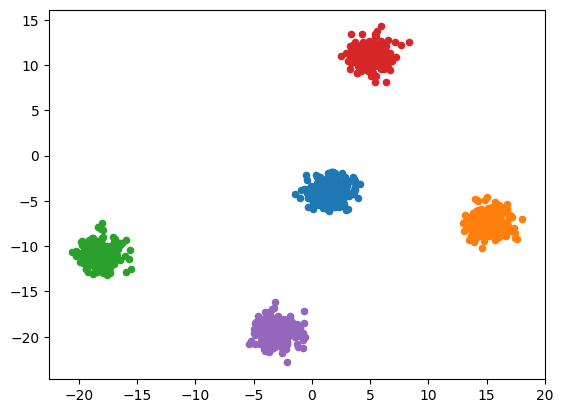

In [4]:
from IPython.utils.sysinfo import num_cpus

# numero di cluster
K = 5

# dimensione del campione
d = 2

# numero di sample
N = 1000

seed = 2001
key = random.PRNGKey(seed)
# vectors of mean of clusters
sigma = 10
mu = random.normal(key,(K,d))*sigma

# cluster assignment
key = random.PRNGKey(2)
c = random.categorical(key,(1/K)*jnp.ones(shape=(K,)),axis=0,shape=(N,))
C = np.zeros(shape=(N,K))
for i in range(N):
  C[i,c[i]] = 1
C = jnp.array(C)

# Data
X = jnp.matmul(C,mu) + random.normal(key,(N,d))
import matplotlib.pyplot as plt

for i in range(K):
  plt.scatter(X[c==i,0], X[c==i,1], s = 20)
plt.show()

Implementation of MCMC in STAN(based on hamiltonian MC)

In [ ]:
gaussian_mix_uni = """
data {
  int N;
  int K;
  int d;
  matrix[N, d] y;
  vector[d] mu0;
  real <lower=0> sigma0;
}

parameters {
  matrix[K,d] means;
  simplex[K] weights;
}

transformed parameters {
}

model {

   //Likelihood
   vector[K] contributions;
   for (i in 1:N){
     for (k in 1:K){
      contributions[k] = log(weights[k]) + multi_normal_lpdf(y[i] | means[k], diag_matrix(rep_vector(1,d)));
      }
      target += log_sum_exp(contributions);
    }


   // Prior
   for(k in 1:K){
    means[k] ~ multi_normal(mu0, sigma0 * diag_matrix(rep_vector(1,d)));
   }
   weights ~ dirichlet(rep_vector(1,K));


}

generated quantities{
  array [N] int cluster_allocs;
  matrix [N,K] phi;
  for(i in 1:N){
    vector [K] log_probs = log(weights);
    for(k in 1:K){
      log_probs[k] += multi_normal_lpdf(y[i] | means[k], diag_matrix(rep_vector(1,d)));
      }
    phi[i] = to_row_vector(softmax(log_probs));
    cluster_allocs[i] = categorical_rng(softmax(log_probs));
  }
}
"""

# Write stan model to file
stan_file = "./stan/gaussian_mix_uni.stan"
with open(stan_file, "w") as f:
    print(gaussian_mix_uni, file=f)

# Compile stan model
gaussian_mix_uni = CmdStanModel(stan_file=stan_file)

In [ ]:
# Input data
gmm_data = {
    "N": N,
    "K": K,
    "d": d,
    "y": X.tolist(),
    "mu0": np.full(d,0.0),
    "sigma0": 10.0,
}

# Algorithm parameters
algo_params = {
    "n_chains": 1,
    "n_burnin": 1000,
    "n_iter": 2000,
}

# Sample
gmm_fit = gaussian_mix_uni.sample(data=gmm_data, chains=algo_params["n_chains"], parallel_chains=algo_params["n_chains"],
                                  iter_warmup=algo_params["n_burnin"], iter_sampling=algo_params["n_iter"])
# Convert to arviz data type
chains = az.from_cmdstanpy(gmm_fit)

In [ ]:
az.plot_trace(chains, var_names=["means"], compact=False)
plt.tight_layout()
plt.show()

In [ ]:
gmm_fit.summary()

In [15]:
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp

def plot_clusters(data, phi, means):
    # Get the cluster assignments
    cluster_assignments = jnp.argmax(phi, axis=1)

    # Number of clusters
    num_clusters = means.shape[0]

    # Create a list of colors for plotting
    #colors = plt.colormaps()
    colors=mcp.gen_color(cmap="winter",n=6)
    print(colors)

    # Scatter plot each data point with its assigned color
    plt.figure(figsize=(8, 6))
    for cluster in range(num_clusters):
        plt.scatter(data[cluster_assignments == cluster, 0], data[cluster_assignments == cluster, 1], c=colors[cluster], label=f'Cluster {cluster}')

    # Plot the cluster means
    for cluster in range(num_clusters):
        plt.scatter(means[cluster, 0], means[cluster, 1], marker='x', color='red', s=100, label=f'Mean Cluster {cluster}')

    plt.legend()
    plt.title('Cluster Visualization')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

In [ ]:
plot_clusters(X, phi_likelihood, means)